# Train DDC Model for Conditional Generation

In [1]:
# change working path to the current file
%cd ..

/home/hudongcheng/Desktop/bo_osda_generator


In [2]:
import numpy as np
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn import functional as F
from tqdm import tqdm
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
import torch.backends.cudnn as cudnn

# import custom modules
from models.ddc import SMILESGenerator
from utils.utils import *
from datasets.data_loader import *
from utils.plot_figures import *

In [3]:
cudnn.benchmark = True
cudnn.enabled = True

train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []

log_dir = './logs/'
save_best_weight_path = './checkpoints/'

now = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')

In [4]:
# read the data and convert to the format we need
train_smiles = read_strings('./data/train_smiles.csv', idx=False)
train_zeo = read_vec('./data/train_zeo.csv', idx=False)
train_syn = read_vec('./data/train_syn.csv', idx=False)
train_codes = read_strings('./data/train_codes.csv', idx=False)
test_smiles = read_strings('./data/test_smiles.csv', idx=False)
test_zeo = read_vec('./data/test_zeo.csv', idx=False)
test_syn = read_vec('./data/test_syn.csv', idx=False)
test_codes = read_strings('./data/test_codes.csv', idx=False)

charset = '?P25$]FO-S.Hc=71(ln63NC4[+)^@'
charlen = len(charset)
print('the charset(inculde begin end and pad char) achieved from dataset :', charset)
print('the total num of charset is :', charlen)
# create the char to index and index to char dictionary
char_to_index = dict((c, i) for i, c in enumerate(charset))
index_to_char = dict((i, c) for i, c in enumerate(charset))
char_list = [k for k, v in char_to_index.items()]

the charset(inculde begin end and pad char) achieved from dataset : ?P25$]FO-S.Hc=71(ln63NC4[+)^@
the total num of charset is : 29


In [5]:
# hyperparameters
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 512
epoch = 10
seqlen = 127

In [6]:
src_smiles, tgt_smiles = smiles_padding(train_smiles)
tgt_seq = smiles_to_sequence(tgt_smiles, char_to_index)
tgt_seq = torch.cat([torch.unsqueeze(seq, 0) for seq in tgt_seq]).long()
src_smiles_test, tgt_smiles_test = smiles_padding(test_smiles)
tgt_seq_test = smiles_to_sequence(tgt_smiles_test, char_to_index)
tgt_seq_test = torch.cat([torch.unsqueeze(seq, 0) for seq in tgt_seq_test]).long()
# create the dataset and dataloader
train_dataset = SeqDataset(train_zeo, train_syn, tgt_seq)
test_dataset = SeqDataset(test_zeo, test_syn, tgt_seq_test)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# create the model
model = SMILESGenerator(condition_dim=24, lstm_dim=256, dec_layers=3, charset_size=charlen).to(device)
# loss
loss_func = torch.nn.CrossEntropyLoss(ignore_index=char_to_index['?'])
optim = torch.optim.Adam(model.parameters(), lr=6e-4)
total = sum(p.numel() for p in model.parameters())
print('total parameters: %0.2fM' % (total / 1e6))

total parameters: 1.39M


In [7]:
# train function
def train(model, dataloader, loss_func, optim, device):
    model.train()
    total_loss = 0
    total_acc = 0
    total_num = 0
    for i, (zeo, syn, tgt) in enumerate(tqdm(dataloader)):
        zeo = zeo.to(device)
        syn = syn.to(device)
        tgt = tgt.to(device)
        # teacher forcing
        condition = torch.cat([zeo, syn], dim=-1)
        tgt_input = tgt[:, :-1].contiguous()
        tgt_output = tgt[:, 1:].contiguous()
        # convert the tgt_input to one-hot
        tgt_input = F.one_hot(tgt_input, num_classes=charlen).float()
        
        optim.zero_grad()
        output = model(condition, tgt_input)
        
        # reshape the output to calculate the loss
        output = output.view(-1, output.size(-1))
        tgt_output = tgt_output.view(-1)
        loss = loss_func(output, tgt_output)
        
        # backward and update
        loss.backward()
        optim.step()
        
        # calculate the accuracy and loss
        total_loss += loss.item()
        pred = output.argmax(dim=-1)
        num_correct = (pred == tgt_output) & (tgt_output != char_to_index['?'])
        num_words = (tgt_output != char_to_index['?']).sum().item()
        total_acc += num_correct.sum().item()
        total_num += num_words
    return total_loss / len(dataloader), total_acc / total_num

In [8]:
# test function
def test(model, dataloader, loss_func, device):
    model.eval()
    total_loss = 0
    total_acc = 0
    total_num = 0
    with torch.no_grad():
        for i, (zeo, syn, tgt) in enumerate(tqdm(dataloader)):
            zeo = zeo.to(device)
            syn = syn.to(device)
            tgt = tgt.to(device)
            condition = torch.cat([zeo, syn], dim=-1)
            tgt_input = tgt[:, :-1].contiguous()
            tgt_output = tgt[:, 1:].contiguous()
            tgt_input = F.one_hot(tgt_input, num_classes=charlen).float()
            output = model(condition, tgt_input)
            output = output.view(-1, output.size(-1))
            tgt_output = tgt_output.view(-1)
            loss = loss_func(output, tgt_output)
            total_loss += loss.item()
            pred = output.argmax(dim=-1)
            num_correct = (pred == tgt_output) & (tgt_output != char_to_index['?'])
            num_words = (tgt_output != char_to_index['?']).sum().item()
            total_acc += num_correct.sum().item()
            total_num += num_words
    return total_loss / len(dataloader), total_acc / total_num

In [9]:
# train the model
for i in range(epoch):
    train_loss, train_acc = train(model, train_dataloader, loss_func, optim, device)
    test_loss, test_acc = test(model, test_dataloader, loss_func, device)
    print('epoch %d, train loss %.4f, train acc %.4f, test loss %.4f, test acc %.4f' % (i, train_loss, train_acc, test_loss, test_acc))
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    test_loss_history.append(test_loss)
    test_acc_history.append(test_acc)
    if i == 0:
        best_acc = test_acc
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), os.path.join(save_best_weight_path, 'best_ddc_model.pth'))
    torch.save(model.state_dict(), os.path.join(save_best_weight_path, 'last_ddc_model.pth'))


100%|██████████| 68/68 [00:00<00:00, 91.67it/s]


epoch 0, train loss 1.9554, train acc 0.4202, test loss 1.5225, test acc 0.5135


100%|██████████| 68/68 [00:00<00:00, 91.06it/s]


epoch 1, train loss 1.3777, train acc 0.5493, test loss 1.2971, test acc 0.5708


100%|██████████| 68/68 [00:00<00:00, 94.50it/s]


epoch 2, train loss 1.2037, train acc 0.5919, test loss 1.1425, test acc 0.6136


100%|██████████| 68/68 [00:00<00:00, 91.69it/s]


epoch 3, train loss 1.0705, train acc 0.6298, test loss 1.0593, test acc 0.6324


100%|██████████| 68/68 [00:00<00:00, 91.38it/s]


epoch 4, train loss 0.9720, train acc 0.6579, test loss 0.9852, test acc 0.6552


100%|██████████| 68/68 [00:00<00:00, 94.97it/s]


epoch 5, train loss 0.9019, train acc 0.6782, test loss 0.9113, test acc 0.6750


100%|██████████| 68/68 [00:00<00:00, 94.52it/s]


epoch 6, train loss 0.8469, train acc 0.6941, test loss 0.8546, test acc 0.6937


100%|██████████| 68/68 [00:00<00:00, 94.71it/s]


epoch 7, train loss 0.8018, train acc 0.7079, test loss 0.8537, test acc 0.6902


100%|██████████| 68/68 [00:00<00:00, 93.96it/s]


epoch 8, train loss 0.7666, train acc 0.7186, test loss 0.7876, test acc 0.7122


100%|██████████| 68/68 [00:00<00:00, 91.48it/s]

epoch 9, train loss 0.7347, train acc 0.7278, test loss 0.7681, test acc 0.7170


In [10]:
def generate_ddc(model, start_sequence, condition, seqlen, 
                 char_to_index, index_to_char, device, temperature=0.5):
    """
    Auto-regressively generate SMILES sequence

    Args: 
        model (nn.Module): The SMILESGenerator (or similar) model.
        start_sequence (torch.Tensor): Already-converted indices for the initial tokens.
            Can be of shape (batch_size, start_len) or (start_len,) if batch_size = 1.
        condition (torch.Tensor): The condition tensor of shape (batch_size, condition_dim).
        seqlen (int): The total desired length of the SMILES (including start tokens).
        char_to_index (dict): Mapping from character to integer index.
        index_to_char (dict): Mapping from integer index back to character.
        device (torch.device): The device on which to run the generation.
        temperature (float): Temperature for sampling.

    Returns:
        If batch_size == 1, returns a single SMILES string.
        Otherwise, returns a list of SMILES strings, one for each item in the batch.
    """

    model.eval()
    
    # 1) If start_sequence is 1D, we assume batch_size = 1. Make it (1, start_len).
    if start_sequence.dim() == 1:
        start_sequence = start_sequence.unsqueeze(0)  # shape: (1, start_len)
    start_sequence = start_sequence.to(device)

    # 2) Determine batch_size and starting sequence length
    batch_size, start_len = start_sequence.size()

    # 3) Create a (batch_size, seqlen) tensor for token indices 
    #    Initialize all to 0, then copy in the start_sequence for each batch example
    generated_seq = torch.zeros(batch_size, seqlen, dtype=torch.long, device=device)
    generated_seq[:, :start_len] = start_sequence
    
    with torch.no_grad():
        # We will iteratively fill positions from [start_len ... seqlen-1]
        for t in range(start_len, seqlen):

            # 4) One-hot encode the tokens up to current time step t
            #    shape -> (batch_size, t, charset_size)
            dec_input = F.one_hot(generated_seq[:, :t], 
                                  num_classes=len(char_to_index)).float()

            # 5) Get the model output
            #    output.shape = (batch_size, t, charset_size)
            output = model(condition, dec_input)

            # 6) Get the logits for the *last* time step (index = t-1)
            #    output[:, -1, :].shape = (batch_size, charset_size)
            last_step_logits = output[:, -1, :]

            # 7) Sample from these logits using temperature
            probs = F.softmax(last_step_logits / temperature, dim=-1)
            sampled_idx = torch.multinomial(probs, 1).squeeze(1)  # shape: (batch_size,)

            # 8) Update generated_seq
            #    But we can also stop if the previous token was '$' (end-of-sequence)
            end_token_idx = char_to_index.get('$', None)
            for b in range(batch_size):
                if end_token_idx is not None and generated_seq[b, t-1] == end_token_idx:
                    # If the previous character was already end-of-sequence,
                    # we do not overwrite. We just leave future steps as 0.
                    continue
                generated_seq[b, t] = sampled_idx[b]
    
    # ----------------------------------------------------------------------
    # Convert token indices back to SMILES strings,
    # stopping at the first '$' if encountered.
    # ----------------------------------------------------------------------
    smiles_outputs = []
    for b in range(batch_size):
        tokens = []
        for idx in generated_seq[b]:
            ch = index_to_char[idx.item()]
            if ch == '$':
                break
            elif ch == '^':
                continue
            tokens.append(ch)
        smiles_outputs.append("".join(tokens))
    
    # Return single string if batch_size == 1, otherwise a list
    if batch_size == 1:
        return smiles_outputs[0]
    else:
        return smiles_outputs


In [11]:
# test the generate function
# check the first 10 samples
train_zeo = train_zeo[:10].astype(np.float32)
train_syn = train_syn[:10].astype(np.float32)
zeo = torch.tensor(train_zeo, dtype=torch.float32).to(device)
syn = torch.tensor(train_syn, dtype=torch.float32).to(device)
target_smi = train_smiles[:10]
start_sequence = torch.full((10, 1), char_to_index['^'], dtype=torch.long)
start_sequence = start_sequence.to(device)
condition_synthesis = torch.cat([zeo, syn], dim=1)
generated_smiles = generate_ddc(model, start_sequence, condition_synthesis, seqlen, char_to_index, index_to_char, device, 0.5)
print('target smiles:')
print(target_smi)
print('generated smiles:')
print(generated_smiles)

target smiles:
[['n1(C)c(C)[n+](cc1)Cc1ccccc1C[n+]1ccn(C)c1C']
 ['Cn1cc[n+](Cc2ccccc2C[n+]2ccn(C)c2C)c1C']
 ['Cc1n(C)cc[n+]1Cc1c(cccc1)C[n+]1ccn(c1C)C']
 ['c1ccc(c(c1)C[n+]1c(C)n(C)cc1)C[n+]1ccn(c1C)C']
 ['[n+]1(c(n(C)cc1)C)Cc1c(C[n+]2ccn(c2C)C)cccc1']
 ['Cc1n(C)cc[n+]1Cc1ccccc1C[n+]1c(n(cc1)C)C']
 ['Cn1c(C)[n+](cc1)Cc1ccccc1C[n+]1ccn(c1C)C']
 ['c1c[n+](Cc2ccccc2C[n+]2c(C)n(cc2)C)c(C)n1C']
 ['n1(cc[n+](c1C)Cc1ccccc1C[n+]1ccn(C)c1C)C']
 ['[n+]1(Cc2c(C[n+]3c(n(cc3)C)C)cccc2)c(C)n(C)cc1']]
generated smiles:
['^c1cC(c)c(C1nccc[[++12cc((())C)ncC2)ccCccc', '^ccc(ccCPnnCn[[+]1cCnncc))', '^cccCc(ccn)C)-11[n+](cc(c))))', '^C(1CC[C+](()1CCC)CC[)+]1(C)(CCCC1)C', '^c1[(+](C))CCc3ccCccc3C[n+]3ccC(C(c)c)4)c2ncccC)', '^c1cccCc(c[)+11CnCccCcnnc', '^cN2ccc(cc1)C[N+]12CCCCCC122C(C)CCC1CCC', '^c((2(((C)))c)ccn1CCNCCO1CONCOOC1OCC(OC2NCCOCCOOCOOCOOCOOC(C)CCO2COOCOOC1CCOC', '^C(C[[+]]]2(C)CCC3C((N2C(C(C)C2)C3CCCC3)C))1', '^c1cCcncccC)n[[+]11nn(cc11CCCCCC)C']


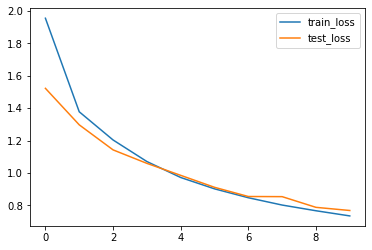

In [12]:
# plot the loss and acc
plot_loss(train_loss_history, test_loss_history, 'ddc')